In [25]:
import spiceypy as spice
import numpy as np

# 1) load a planetary SPK, e.g. de432s.bsp, and leap seconds
spice.furnsh("/Users/rebnoob/Documents/ae105/generic_kernels/lsk/naif0012.tls")
spice.furnsh("/Users/rebnoob/Documents/ae105/generic_kernels/spk/planets/de442.bsp")
spice.furnsh("/Users/rebnoob/Documents/ae105/generic_kernels/spk/vgr2.x2100.bsp")


# 2) convenience
def state_sun_center(target, utc):
    et = spice.utc2et(utc)
    # target w.r.t. Solar System Barycenter (or Sun) in km, km/s
    state, _ = spice.spkezr(target, et, "ECLIPJ2000", "NONE", "SUN")
    r = state[:3]
    v = state[3:]
    return et, r, v

In [6]:
tE = "1977-08-20T00:00:00"
tJ = "1979-07-09T00:00:00"
tS = "1981-08-25T00:00:00"
tU = "1986-01-24T00:00:00"
tN = "1989-08-25T00:00:00"

def sun_state(target, utc):
    et = spice.utc2et(utc)
    # heliocentric ecliptic is fine; lambert only needs consistency
    state, _ = spice.spkezr(target, et, "ECLIPJ2000", "NONE", "SUN")
    r = state[:3]
    v = state[3:]
    return et, r, v

# get states
etE, rE, vE = sun_state("EARTH",              tE)
etJ, rJ, vJ = sun_state("JUPITER BARYCENTER", tJ)
etS, rS, vS = sun_state("SATURN BARYCENTER",  tS)
etU, rU, vU = sun_state("URANUS BARYCENTER",  tU)
etN, rN, vN = sun_state("NEPTUNE BARYCENTER", tN)

In [9]:
from lamberthub import izzo2015

mu_sun = 1.32712440018e11  # km^3/s^2

legs = [
    ("Earth",   rE, vE, etE, "Jupiter", rJ, vJ, etJ),
    ("Jupiter", rJ, vJ, etJ, "Saturn",  rS, vS, etS),
    ("Saturn",  rS, vS, etS, "Uranus",  rU, vU, etU),
    ("Uranus",  rU, vU, etU, "Neptune", rN, vN, etN),
]

vinfs = {}

for dep_name, r1, v1p, t1, arr_name, r2, v2p, t2 in legs:
    tof = t2 - t1  # seconds
    # Solve Lambert’s problem using Izzo 2015
    v1_sc, v2_sc = izzo2015(mu_sun, r1, r2, tof, M=0, prograde=True, low_path=True)
    vinfs[(dep_name, arr_name)] = {
        "v_inf_dep": v1_sc - v1p,
        "v_inf_arr": v2_sc - v2p,
    }


In [10]:
# ----------------------------
# planet GMs and radii (km, km^3/s^2)
bodies = {
    "Jupiter": {"mu": 1.267127641e8, "R": 69911.0},
    "Saturn":  {"mu": 3.79405848418e7, "R": 60268.0},
    "Uranus":  {"mu": 5.7945564e6,     "R": 25559.0},
}

def flyby_altitude(body, vinf_in, vinf_out):
    mu_p = bodies[body]["mu"]
    R_p  = bodies[body]["R"]

    vinf_in_mag  = np.linalg.norm(vinf_in)
    vinf_out_mag = np.linalg.norm(vinf_out)
    vinf_mag     = 0.5*(vinf_in_mag + vinf_out_mag)

    # turn angle
    cos_delta = np.dot(vinf_in, vinf_out) / (vinf_mag**2)
    cos_delta = np.clip(cos_delta, -1.0, 1.0)
    delta = np.arccos(cos_delta)

    # pericenter radius for hyperbolic flyby
    # sin(delta/2) = 1 / (1 + rp * vinf^2 / mu)
    s = np.sin(0.5*delta)
    rp = mu_p / (vinf_mag**2 * (1.0/s - 1.0))
    h  = rp - R_p
    return delta, rp, h


In [11]:
for pl in ["Jupiter", "Saturn", "Uranus"]:
    if pl == "Jupiter":
        vinf_in  = vinfs[("Earth",   "Jupiter")]["v_inf_arr"]
        vinf_out = vinfs[("Jupiter", "Saturn")]["v_inf_dep"]
    elif pl == "Saturn":
        vinf_in  = vinfs[("Jupiter", "Saturn")]["v_inf_arr"]
        vinf_out = vinfs[("Saturn",  "Uranus")]["v_inf_dep"]
    elif pl == "Uranus":
        vinf_in  = vinfs[("Saturn",  "Uranus")]["v_inf_arr"]
        vinf_out = vinfs[("Uranus",  "Neptune")]["v_inf_dep"]

    vminus = np.linalg.norm(vinf_in)
    vplus  = np.linalg.norm(vinf_out)
    delta, rp, h = flyby_altitude(pl, vinf_in, vinf_out)

    print(f"--- {pl} ---")
    print(f"|v_inf_in|  = {vminus:8.4f} km/s")
    print(f"|v_inf_out| = {vplus:8.4f} km/s")
    print(f"diff       = {vplus - vminus: .4e} km/s")
    print(f"turn angle = {np.degrees(delta):6.2f} deg")
    print(f"rp         = {rp:10.1f} km")
    print(f"altitude   = {h:10.1f} km")

--- Jupiter ---
|v_inf_in|  =   7.9060 km/s
|v_inf_out| =   7.7939 km/s
diff       = -1.1204e-01 km/s
turn angle =  96.90 deg
rp         =  6116386.8 km
altitude   =  6046475.8 km
--- Saturn ---
|v_inf_in|  =  10.8337 km/s
|v_inf_out| =  10.6972 km/s
diff       = -1.3649e-01 km/s
turn angle =  85.13 deg
rp         =   684323.6 km
altitude   =   624055.6 km
--- Uranus ---
|v_inf_in|  =  14.7641 km/s
|v_inf_out| =  14.7499 km/s
diff       = -1.4130e-02 km/s
turn angle =  22.94 deg
rp         =     6603.3 km
altitude   =   -18955.7 km


In [30]:
import numpy as np
import spiceypy as spice
from lamberthub import izzo2015   # make sure lamberthub is installed
import pprint

# ------------------------------------------------------------
# 0. SPICE setup (change these to your actual kernel paths)
# ------------------------------------------------------------
# spice.furnsh("naif0012.tls")
# spice.furnsh("de440.bsp")
# spice.furnsh("pck00010.tpc")
# ... add whatever kernels your notebook already uses

# ------------------------------------------------------------
# 1. Constants
# ------------------------------------------------------------
mu_sun = 1.32712440018e11  # km^3/s^2

# Planet GMs [km^3/s^2] and radii [km] for flyby altitude check
planet_data = {
    "JUPITER BARYCENTER": {"mu": 1.26686534e8,  "R": 71492.0},
    "SATURN BARYCENTER":  {"mu": 3.7931206e7,   "R": 60268.0},
    "URANUS BARYCENTER":  {"mu": 5.793939e6,    "R": 25559.0},
    # Neptune skipped for altitude per instructions
}

# ------------------------------------------------------------
# 2. Voyager-2 event times (your problem statement)
# ------------------------------------------------------------
date_strs = {
    "E": "1977-08-20T14:29:00",  # launch
    "J": "1979-07-09T22:29:00",  # Jupiter
    "S": "1981-08-25T03:24:05",  # Saturn
    "U": "1986-01-24T17:59:47",  # Uranus
    "N": "1989-08-25T03:56:36",  # Neptune
}

# convert to ephemeris time
ets = {k: spice.str2et(v) for k, v in date_strs.items()}

# ------------------------------------------------------------
# 3. Legs we want Lambert arcs for
# ------------------------------------------------------------
legs = [
    ("E", "J"),
    ("J", "S"),
    ("S", "U"),
    ("U", "N"),
]

# Map short names to SPICE bodies (heliocentric)
body_map = {
    "E": "EARTH",
    "J": "JUPITER BARYCENTER",
    "S": "SATURN BARYCENTER",
    "U": "URANUS BARYCENTER",
    "N": "NEPTUNE BARYCENTER",
}

# ------------------------------------------------------------
# 4. Storage
# ------------------------------------------------------------
vinfs = {}            # (dep, arr) -> {"vinf_out": ..., "vinf_in": ...}
flyby_altitudes = {}  # arr -> altitude implied by patched-conic

# ------------------------------------------------------------
# 5. Main loop over legs
# ------------------------------------------------------------
for dep_name, arr_name in legs:
    et_dep = ets[dep_name]
    et_arr = ets[arr_name]
    tof = et_arr - et_dep  # seconds

    # 5a. planet heliocentric states
    dep_state, _ = spice.spkezr(body_map[dep_name], et_dep, "J2000", "NONE", "SUN")
    arr_state, _ = spice.spkezr(body_map[arr_name], et_arr, "J2000", "NONE", "SUN")

    r1 = np.array(dep_state[0:3])
    v_dep_planet = np.array(dep_state[3:6])

    r2 = np.array(arr_state[0:3])
    v_arr_planet = np.array(arr_state[3:6])

    # 5b. Lambert using lamberthub izzo2015
    # keeping your exact call signature:
    v1_sc, v2_sc = izzo2015(mu_sun, r1, r2, tof, M=0, prograde=True, low_path=True)

    # 5c. hyperbolic-excess velocities
    vinf_out = v1_sc - v_dep_planet   # leaving dep planet
    vinf_in  = v2_sc - v_arr_planet   # arriving at arr planet

    vinfs[(dep_name, arr_name)] = {
        "vinf_out": vinf_out,
        "vinf_in":  vinf_in,
    }

# ------------------------------------------------------------
# 6. Compare v_inf at each flyby and reconstruct altitude
# ------------------------------------------------------------
flyby_sequence = ["J", "S", "U"]   # Neptune skipped for altitude

for planet_short in flyby_sequence:
    if planet_short == "J":
        vinf_in_vec  = vinfs[("E", "J")]["vinf_in"]
        vinf_out_vec = vinfs[("J", "S")]["vinf_out"]
    elif planet_short == "S":
        vinf_in_vec  = vinfs[("J", "S")]["vinf_in"]
        vinf_out_vec = vinfs[("S", "U")]["vinf_out"]
    elif planet_short == "U":
        vinf_in_vec  = vinfs[("S", "U")]["vinf_in"]
        vinf_out_vec = vinfs[("U", "N")]["vinf_out"]

    vinf_in_mag  = np.linalg.norm(vinf_in_vec)
    vinf_out_mag = np.linalg.norm(vinf_out_vec)

    # turn angle between incoming and outgoing
    cos_delta = np.dot(vinf_in_vec, vinf_out_vec) / (vinf_in_mag * vinf_out_mag)
    cos_delta = np.clip(cos_delta, -1.0, 1.0)
    delta = np.arccos(cos_delta)  # radians

    planet_name = body_map[planet_short]
    mu_p = planet_data[planet_name]["mu"]
    R_p  = planet_data[planet_name]["R"]

    # H = (1/sin(delta/2) - 1) * mu / vinf^2 - R
    sin_half = np.sin(delta / 2.0)
    rp = (1.0 / sin_half - 1.0) * mu_p / (vinf_in_mag ** 2)
    H  = rp - R_p

    flyby_altitudes[planet_short] = {
        "vinf_in_mag":  vinf_in_mag,
        "vinf_out_mag": vinf_out_mag,
        "delta_deg":    np.degrees(delta),
        "H_pc_km":      H,
    }

# ------------------------------------------------------------
# 7. Print results
# ------------------------------------------------------------
print("=== v_infty match check ===")
for planet_short in flyby_sequence:
    d = flyby_altitudes[planet_short]
    print(
        f"{planet_short}: |v_inf_in| = {d['vinf_in_mag']:.6f} km/s, "
        f"|v_inf_out| = {d['vinf_out_mag']:.6f} km/s, "
        f"diff = {d['vinf_in_mag'] - d['vinf_out_mag']:.6f} km/s"
    )

print("\n=== patched-conic implied altitudes ===")
for planet_short in flyby_sequence:
    d = flyby_altitudes[planet_short]
    print(
        f"{planet_short}: delta = {d['delta_deg']:.3f} deg, "
        f"H_pc = {d['H_pc_km']:.1f} km"
    )

# from pprint import pprint
    pprint.pprint(vinfs)

=== v_infty match check ===
J: |v_inf_in| = 7.888596 km/s, |v_inf_out| = 7.803391 km/s, diff = 0.085205 km/s
S: |v_inf_in| = 10.839790 km/s, |v_inf_out| = 10.691356 km/s, diff = 0.148434 km/s
U: |v_inf_in| = 14.757537 km/s, |v_inf_out| = 14.756513 km/s, diff = 0.001023 km/s

=== patched-conic implied altitudes ===
J: delta = 96.844 deg, H_pc = 614166.8 km
{('E', 'J'): {'vinf_in': array([-0.57213021,  7.47326529,  2.46026855]),
              'vinf_out': array([2.31783778, 7.43663   , 6.50833339])},
 ('J', 'S'): {'vinf_in': array([-10.37054827,  -3.06070309,  -0.76477365]),
              'vinf_out': array([-7.64356399, -1.57119781,  0.01351405])},
 ('S', 'U'): {'vinf_in': array([  0.52057072, -13.36830641,  -6.22914743]),
              'vinf_out': array([ 2.16650043, -9.4077246 , -4.59413611])},
 ('U', 'N'): {'vinf_in': array([  7.47238888, -14.04007193,  -5.22348786]),
              'vinf_out': array([  6.11749278, -12.59928841,  -4.64638511])}}
S: delta = 85.129 deg, H_pc = 94156.3 km


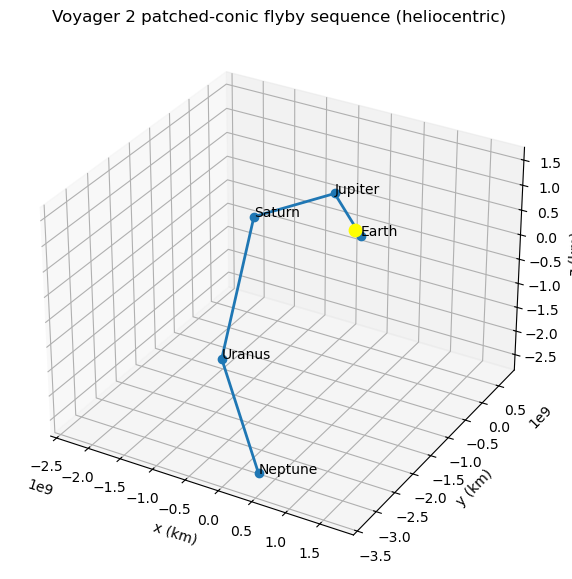

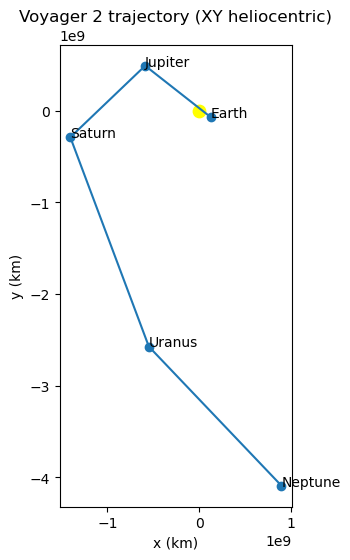

In [31]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# 1) collect the heliocentric positions at the encounter times
planet_order = ["E", "J", "S", "U", "N"]
planet_xyz = []

for p in planet_order:
    state, _ = spice.spkezr(body_map[p], ets[p], "J2000", "NONE", "SUN")
    planet_xyz.append(np.array(state[0:3]))

planet_xyz = np.array(planet_xyz)  # shape (5, 3)

# 2) make a 3D plot: polyline through the encounters
fig = plt.figure(figsize=(8, 7))
ax = fig.add_subplot(111, projection='3d')

# plot the trajectory (just connect the encounter points)
ax.plot(planet_xyz[:, 0], planet_xyz[:, 1], planet_xyz[:, 2],
        marker='o', linestyle='-', linewidth=2)

# label points
for i, name in enumerate(["Earth", "Jupiter", "Saturn", "Uranus", "Neptune"]):
    ax.text(planet_xyz[i, 0], planet_xyz[i, 1], planet_xyz[i, 2], name)

# plot the Sun at origin
ax.scatter(0, 0, 0, color='yellow', s=80)

ax.set_xlabel("x (km)")
ax.set_ylabel("y (km)")
ax.set_zlabel("z (km)")
ax.set_title("Voyager 2 patched-conic flyby sequence (heliocentric)")

# make it a bit nicer: equal-ish aspect
max_range = (planet_xyz.max(axis=0) - planet_xyz.min(axis=0)).max()
mid = planet_xyz.mean(axis=0)
for axis, m in zip([ax.set_xlim, ax.set_ylim, ax.set_zlim], mid):
    axis(m - max_range/2, m + max_range/2)

plt.show()

# 3) also do an XY projection to see it top-down
plt.figure(figsize=(7, 6))
plt.plot(planet_xyz[:, 0], planet_xyz[:, 1], marker='o', linestyle='-')
for i, name in enumerate(["Earth", "Jupiter", "Saturn", "Uranus", "Neptune"]):
    plt.text(planet_xyz[i, 0], planet_xyz[i, 1], name)

plt.scatter(0, 0, color='yellow', s=80)
plt.gca().set_aspect('equal', 'box')
plt.xlabel("x (km)")
plt.ylabel("y (km)")
plt.title("Voyager 2 trajectory (XY heliocentric)")
plt.show()